In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR_ALN as HALOVI
from complementary_models import HALOMASKVAE_ALN as HALOVAE
import scanpy as sc
import scvi

import pandas as pd
# torch.autograd.set_detect_anomaly(True)

Global seed set to 0


In [3]:
### test whole data with RNA only 
adata_multi = sc.read_h5ad("/gstore/data/tmai/Haiyi/mouse_brain_data/multiomic.h5ad")
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]

adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)

df_meta= pd.read_csv("/gstore/data/tmai/Haiyi/mouse_brain_data/RNA/metadata.tsv",sep = "\t",index_col=0)
bins = df_meta.binned.unique()
times = {}
index = 0
for bin in sorted(bins):
    times[bin] = index
    index += 1

def add_time(row, times):
    timestamp = times[row.binned]
    return timestamp

df_meta['time_key'] = df_meta.apply(lambda row: add_time(row, times), axis=1)

newindex = []

for idx, row in df_meta.iterrows():
    newindex.append(idx+"_paired")

df_meta['Id'] = newindex    

df_meta_sub = df_meta[["Id", 'latent_time']]

df_meta_sub.set_index("Id", inplace=True)
adata_mvi.obs = adata_mvi.obs.join(df_meta_sub, how="inner")
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [4]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [4]:
## load pre-trained models
model = model.load("model_BM_aligned_nocausal", adata_mvi)

INFO     File model_neural_BM_mouse_nocausal_softmax/model.pt already downloaded             
n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [8]:
model.module.set_finetune_params(0)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=500, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 320/500:  64%|██████▍   | 319/500 [10:23<05:49,  1.93s/it, loss=1.89e+05, v_num=1]

/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [9]:
model.save("model_BM_aligned_nocausal",overwrite=True)

In [4]:
model = model.load("model_BM_aligned_causal0065",adata_mvi)

INFO     File model_neural_BM_mouse_causal_0065_softmax2/model.pt already downloaded         
n_genes :14583
n_peaks:123883
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [20]:
model.module.alpha = 0.065
model.module.beta_2 = 1e6
model.module.beta_3 = 1e6
model.module.beta_1 = 1e6
model.module.n_latent_dep = 5
print(model.module.alpha)


0.065


In [21]:
## finetune without L0
model.module.set_finetune_params(2)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=500, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 500/500: 100%|██████████| 500/500 [19:18<00:00,  2.32s/it, loss=1.88e+05, v_num=1]


In [15]:
# model.module.set_gates_finetune(True)
model.module.set_train_params(expr_train=True, acc_train=True)
model.module.set_finetune_params(2)
model.train(max_epochs=600, batch_size=256)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 74/600:  12%|█▏        | 73/600 [04:34<33:09,  3.78s/it, loss=1.27e+05, v_num=1]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [22]:
model.save("model_BM_aligned_causal0065", overwrite=True)

In [33]:
model.module.set_train_params(expr_train=True, acc_train=True)
model.module.set_finetune_params(2)
model.train(max_epochs=50, batch_size=256)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=50 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [03:06<00:00,  3.74s/it, loss=1.43e+05, v_num=1]


In [19]:
model.save("model_neural_BM_mouse_causal_01",overwrite=True)

In [23]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()


In [24]:
path2figdir = "figs/BM/20_aligned"
sc.settings.figdir =path2figdir
sc.set_figure_params(vector_friendly=True)

In [25]:
from complementary_models import torch_infer_nonsta_dir

latent_atac_indep_t = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep_t = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')

score3, _, _ = torch_infer_nonsta_dir(latent_atac_indep_t, latent_expr_indep_t, times)
score4, _, _ = torch_infer_nonsta_dir(latent_expr_indep_t, latent_atac_indep_t, times)
print("score3 {} and score4 {}".format(score3, score4))
score3 - score4

score3 0.03374729269906756 and score4 0.04956251426169723


tensor(-0.0158, device='cuda:0', dtype=torch.float64)

In [26]:
latent_atac_dep_t = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep_t = torch.tensor(latent_expr_dep).to('cuda')
times = torch.tensor(times).to('cuda')

score3, _, _ = torch_infer_nonsta_dir(latent_atac_dep_t, latent_expr_dep_t, times)
score4, _, _ = torch_infer_nonsta_dir(latent_expr_dep_t, latent_atac_dep_t, times)
print("score3 {} and score4 {}".format(score3, score4))
score3 - score4

/local/18624152/ipykernel_25249/2827984348.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times = torch.tensor(times).to('cuda')


score3 0.0646762388819029 and score4 0.06462660840835509


tensor(4.9630e-05, device='cuda:0', dtype=torch.float64)

/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 

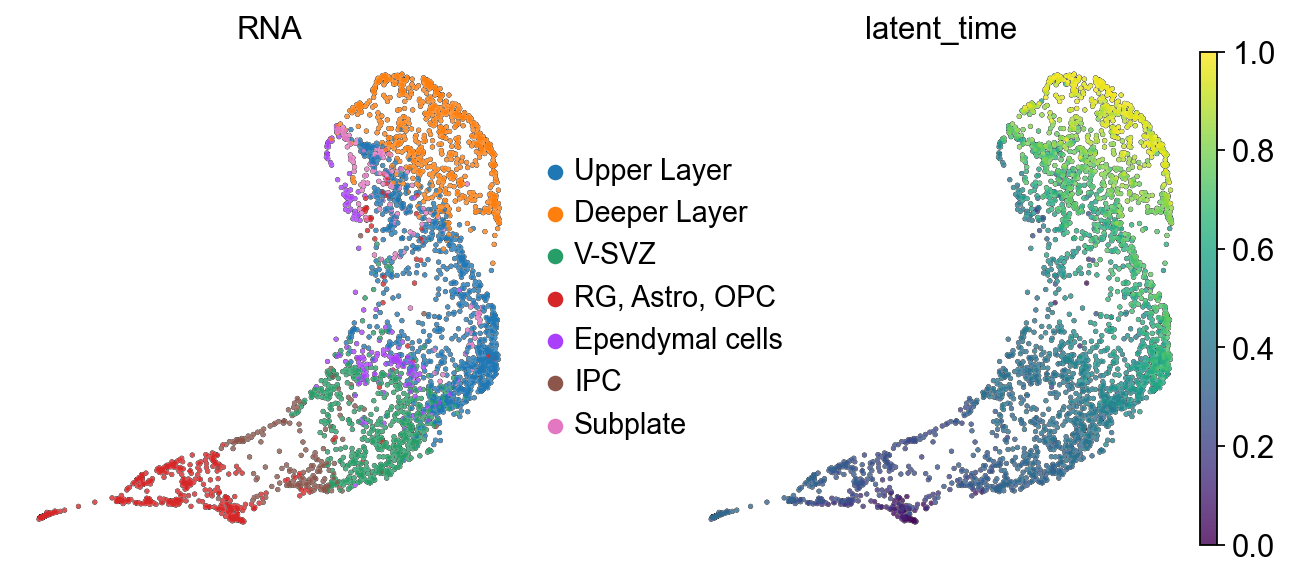

In [13]:
adata_mvi.obsm["latent"] = latent_expr

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.2)



sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['celltype', "latent_time"], title="RNA")


/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 

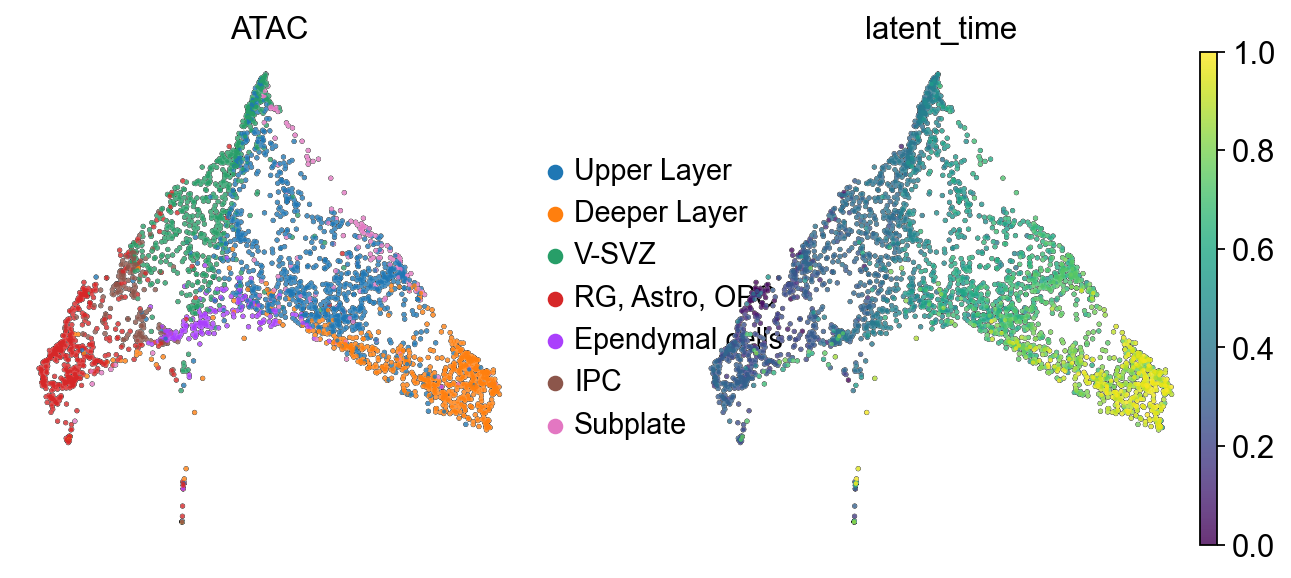

In [14]:
adata_mvi.obsm["latent"] = latent_acc

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.2)

sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['celltype', "latent_time"], title="ATAC")          

## Causal Representation

/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 

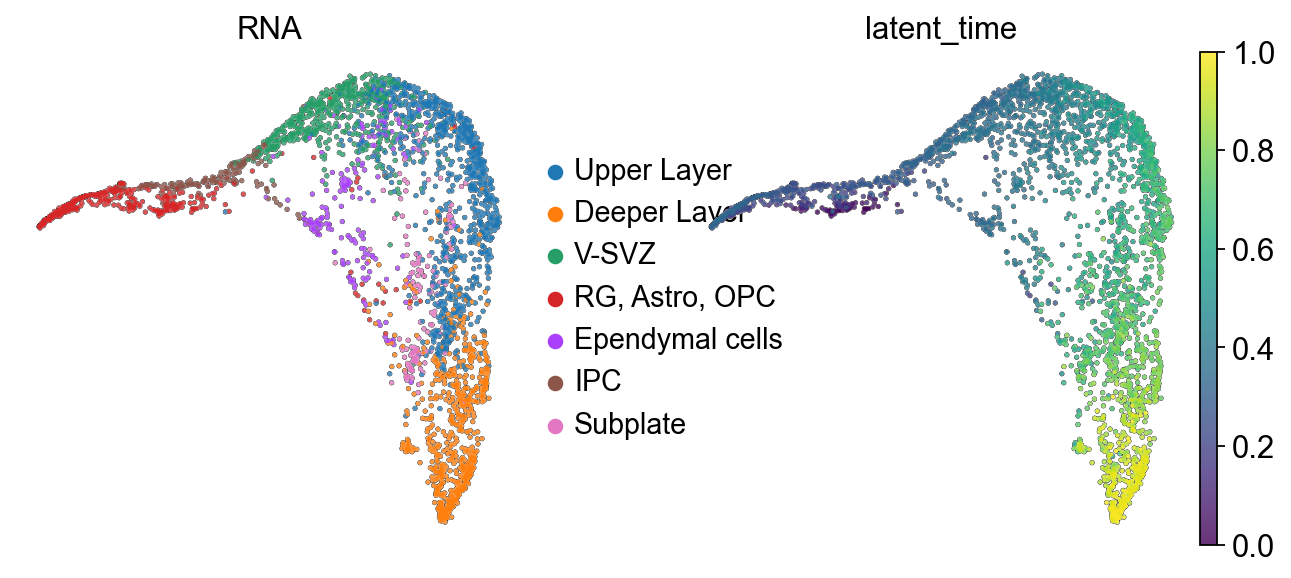

In [27]:
adata_mvi.obsm["latent"] = latent_expr
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1)

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)


sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['celltype', 'latent_time'], title="RNA")

/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 

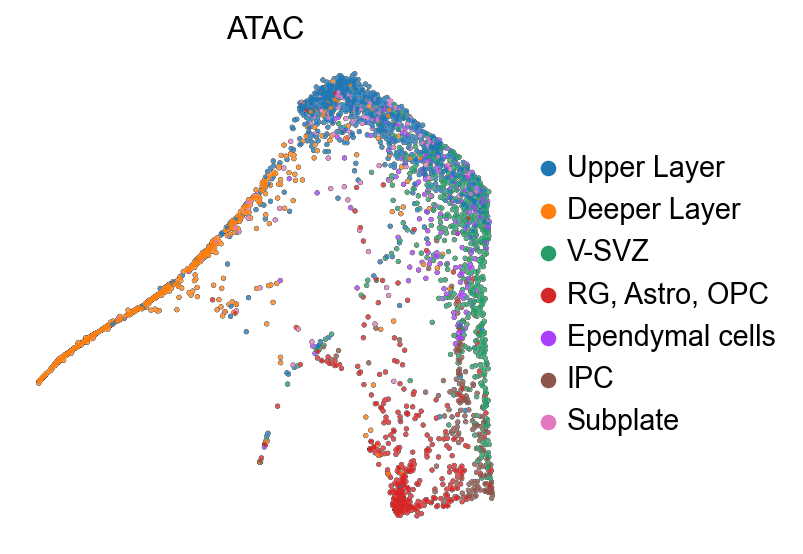

/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


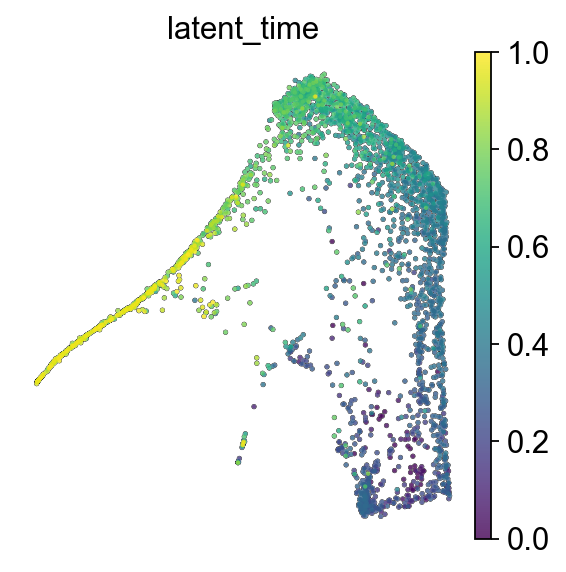

In [28]:
save_path = "_ATAC.pdf"
save_path2 = "_ATAC_latent.pdf"

adata_mvi.obsm["latent"] = latent_acc
# sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15)
# sc.tl.umap(adata_mvi, min_dist=0.1)


sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1)

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)


sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['celltype'], title="ATAC")

sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['latent_time'], title="latent_time")


# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
#           outline_width=(0.1,0), color=['celltype'], title="ATAC", save=save_path)

# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
#           outline_width=(0.1,0), color=['latent_time'], title="latent_time", save=save_path2)


Epoch 320/500:  64%|██████▍   | 319/500 [42:19<24:00,  7.96s/it, loss=1.89e+05, v_num=1]


/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


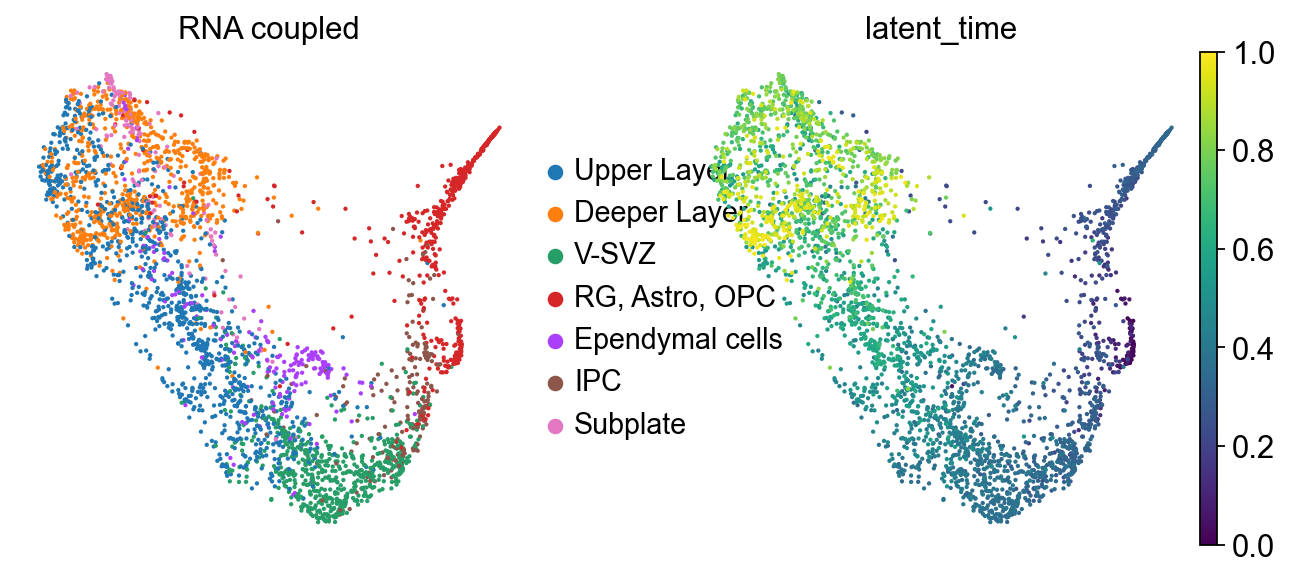

In [29]:
save_path = "_RNA_coupled.pdf"
save_path2 = "_RNA_coupled_latent.pdf"


adata_mvi.obsm["latent"] =latent_expr_dep
# sc.pp.neighbors(adata_mvi, use_rep="latent")



# sc.tl.umap(adata_mvi,min_dist =0.5)

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1)

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

%matplotlib inline
sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=15, alpha = 1, frameon=False, ncols=2,outline_width=(0.1,0), title="RNA coupled")
# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
#           outline_width=(0.1,0), color=['celltype'], title="RNA_coupled", save=save_path)

# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
#           outline_width=(0.1,0), color=['latent_time'], title="latent_time", save=save_path2)    

/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


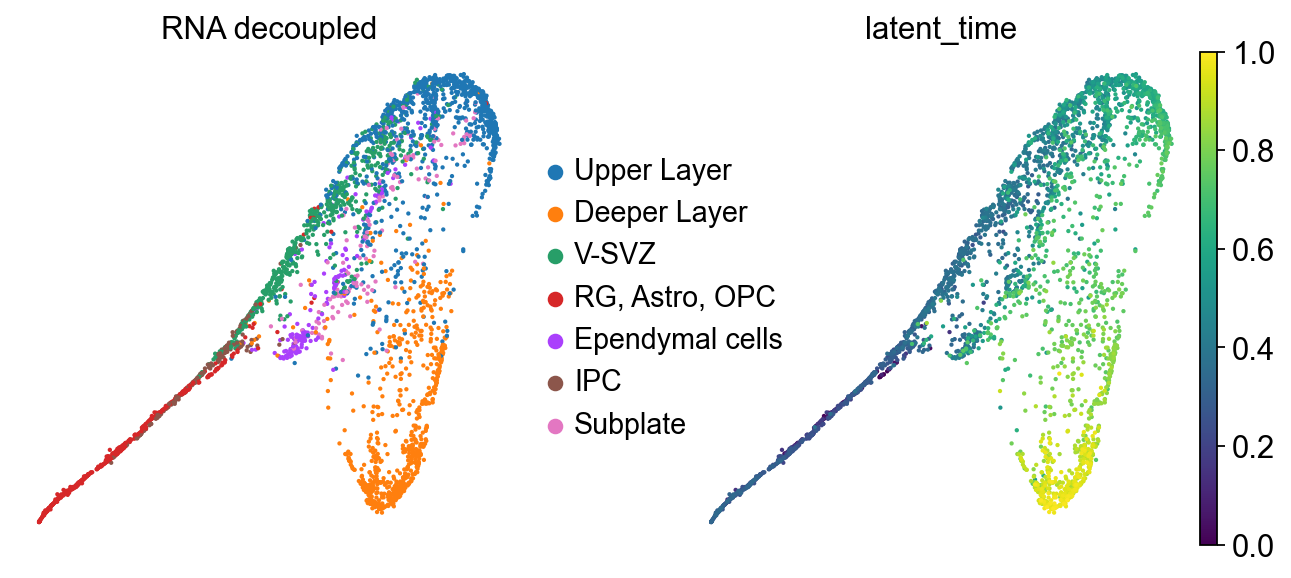

In [30]:
save_path = "_RNA_decoupled.pdf"
save_path2 = "_RNA_decoupled_latent.pdf"


adata_mvi.obsm["latent"] =latent_expr_indep
# sc.pp.neighbors(adata_mvi, use_rep="latent")
# sc.tl.umap(adata_mvi,min_dist =0.1)


sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

%matplotlib inline
sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=15, alpha =1 ,frameon=False, ncols=2, outline_width=(0.1,0), title="RNA decoupled")

# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
#           outline_width=(0.1,0), color=['celltype'], title="RNA decoupled", save=save_path)

# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
#           outline_width=(0.1,0), color=['latent_time'], title="latent_time",save=save_path2)   

/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


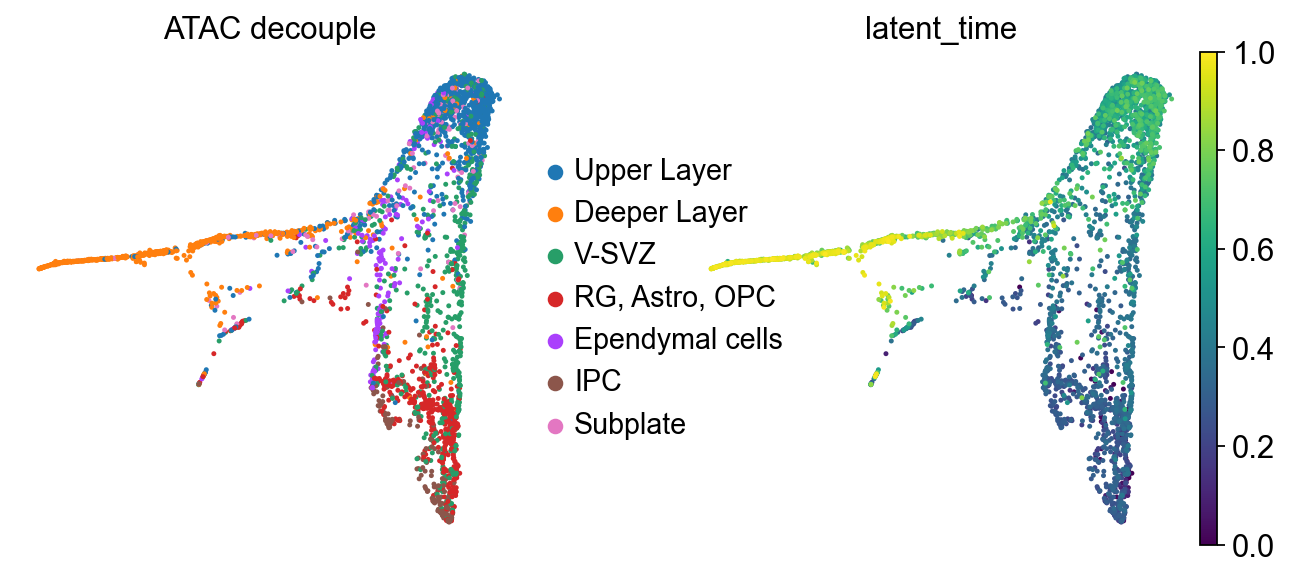

In [31]:
save_path = "_ATAC_decoupled.pdf"
save_path2 = "_ATAC_decoupled_latent.pdf"


adata_mvi.obsm["latent"] =latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=20, frameon=False, ncols=2,outline_width=(0.1,0), title="ATAC decouple", alpha = 1)
# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
#           outline_width=(0.1,0), color=['celltype'], title="ATAC decoupled", save=save_path)

# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
#           outline_width=(0.1,0), color=['latent_time'], title="latent_time", save=save_path2) 

/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


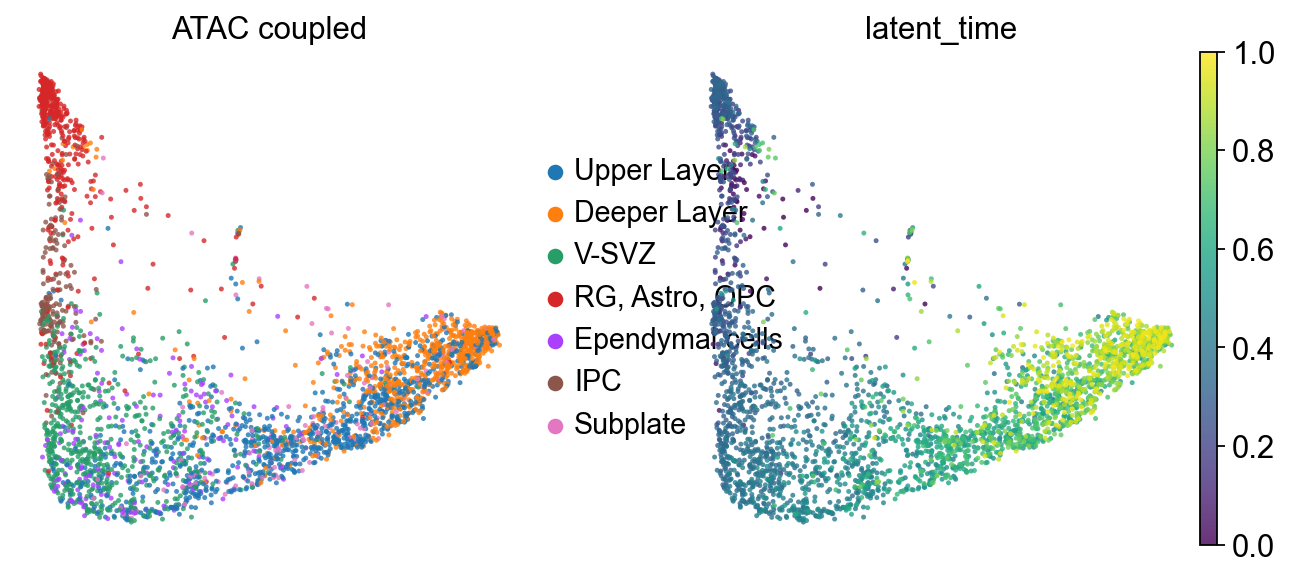

In [32]:
save_path = "_ATAC_coupled.pdf"
save_path2 = "_ATAC_coupled_latent.pdf"

adata_mvi.obsm["latent"] =latent_atac_dep

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=20, frameon=False, ncols=2, outline_width=(0.1, 0), title="ATAC coupled", alpha = 0.8)
# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
#           outline_width=(0.1,0), color=['celltype'], title="ATAC coupled",save=save_path)

# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
#           outline_width=(0.1,0), color=['latent_time'], title="latent_time",save=save_path2) 


/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 

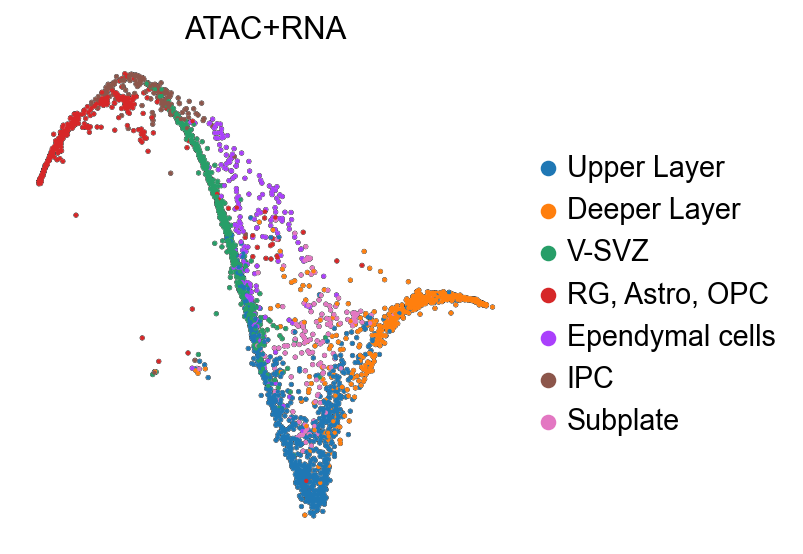

/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/gstore/home/maoh8/.conda/envs/HALO/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


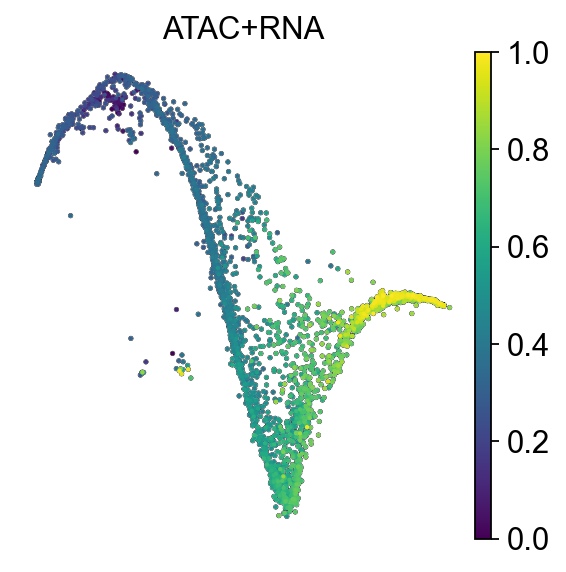

In [33]:
adata_mvi.obsm["latent"] = np.concatenate([latent_acc , latent_expr],axis=1)
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1)

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)

# sc.pl.umap(rna_data, frameon=False, size = 10, alpha = 1, add_outline=True,
#           outline_width=(0.1,0), color='leiden')

figure_name = "_ATAC+RNA"
format = ".pdf"
save_path = figure_name+format
# with plt.rc_context():
sc.set_figure_params(vector_friendly=True)

# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
#         outline_width=(0.1,0), color=['celltype'], title="ATAC+RNA", save=save_path)

sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
        outline_width=(0.1,0), color=['celltype'], title="ATAC+RNA")
sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
        outline_width=(0.1,0), color=['latent_time'], title="ATAC+RNA")

# plt.savefig(save_path, bbox_inches="tight", dpi=300)        

figure_name = "_ATAC+RNA_latenttime"
format = ".pdf"
save_path = figure_name+format

# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
#         outline_width=(0.1,0), color=['latent_time'], title="ATAC+RNA",save=save_path)  
# plt.savefig(save_path, bbox_inches="tight",dpi=300)         


In [5]:
decouple_genes = ['Slc35f1','B3galt1','Nrp1','Kirrel3','Hs6st2', 'Gm29260','Tle4','Kcnk2','Nyap2','Hs3st4']
couple_genes = ['Foxp1','Lrrtm4', 'Vcan','Sik3','Dph6','Rgma','Arhgap20','Itgb3bp','Ttyh1']

In [68]:
decouple_genes = ['ELP4', 'GM49380', 'COL4A1', 'PLD5', 'EPB41L4B', 'P4HA1', 'B3GAT1',
       'CCDC141', 'CD82', 'KIF2C', 'CELSR1', 'OTUD7B', 'GM41414', 'PLCXD2',
       'TOR3A', 'MARCH4', 'PLPPR5', 'GM12631', 'RBM20', 'TPM1', 'ENOX2',
       'HNMT', 'ZCCHC3', 'GM5089', 'KANK1', 'FERMT3', 'BC051142', 'LARP7',
       'MANBA', 'PDPN']

couple_genes = ['SNX8', 'TOP2A', 'TANK', 'ACVR2A', 'TAF4B', 'ATP8B1', 'FERMT3', 'SUMF2',
       'B4GALT1', 'RAMP3', 'DBT', 'SERTAD2', 'CSMD1', 'GIT2', 'MCCC2', 'PTN',
       'SREBF1', 'LMNA', 'SGK1', 'ATR', 'GRB10', 'MC4R', 'RORA', 'MPP7',
       'ZDBF2', 'DLEU2', 'MEIS1', 'CNKSR2', 'SIK3', 'ZEB1']

decouple_genes = [str(e).capitalize() for e in decouple_genes]
couple_genes = [str(e).capitalize() for e in couple_genes]



In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
decoupl_genes = ['Slc35f1','B3galt1','Nrp1','Kirrel3','Hs6st2', 'Gm29260','Tle4','Kcnk2','Nyap2','Hs3st4']
couple_genes = ['Foxp1','Lrrtm4', 'Vcan','Sik3','Dph6','Rgma','Arhgap20','Itgb3bp','Ttyh1']

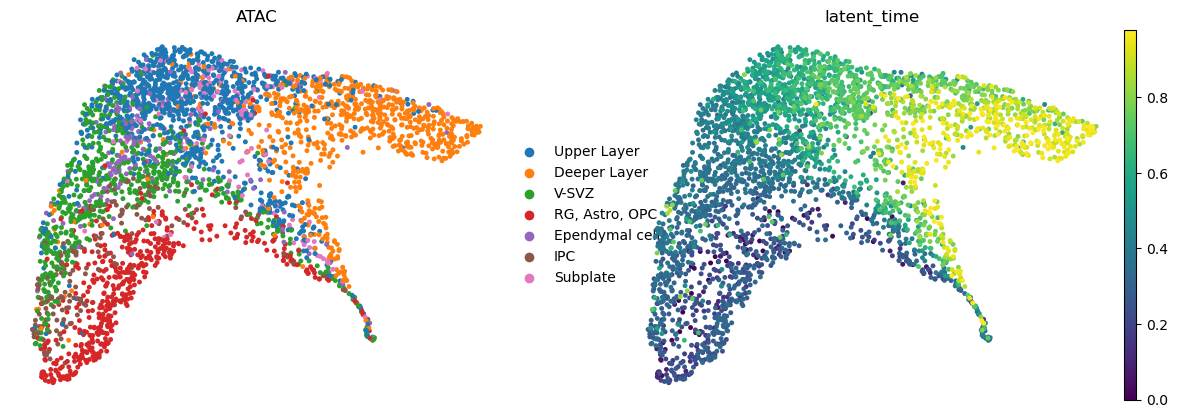

In [12]:
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

plt.show()

In [ ]:
sc.pl.umap(adata_mvi,color=couple_genes, s=50, frameon=False, ncols=3, vmax='p99',  cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["blood"]], as_cmap=True))


In [ ]:
sc.pl.umap(adata_mvi,color=decouple_genes, s=50, frameon=False, ncols=3, vmax='p99',  cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["blood"]], as_cmap=True))


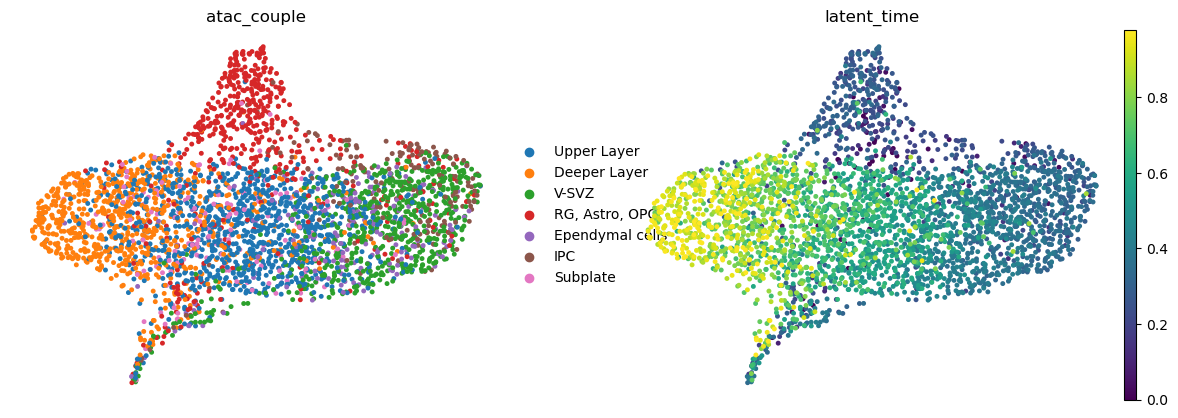

In [18]:
adata_mvi.obsm["latent"] = latent_atac_dep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=15, metric="manhattan")

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="atac_couple")

plt.show()

In [ ]:
sc.pl.umap(adata_mvi,color=couple_genes+['Epha3'], s=50, frameon=False, ncols=3, vmax='p99',  cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["blood"]], as_cmap=True))


In [ ]:
sc.pl.umap(adata_mvi,color=decouple_genes, s=50, frameon=False, ncols=3, vmax='p99',  cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["blood"]], as_cmap=True))


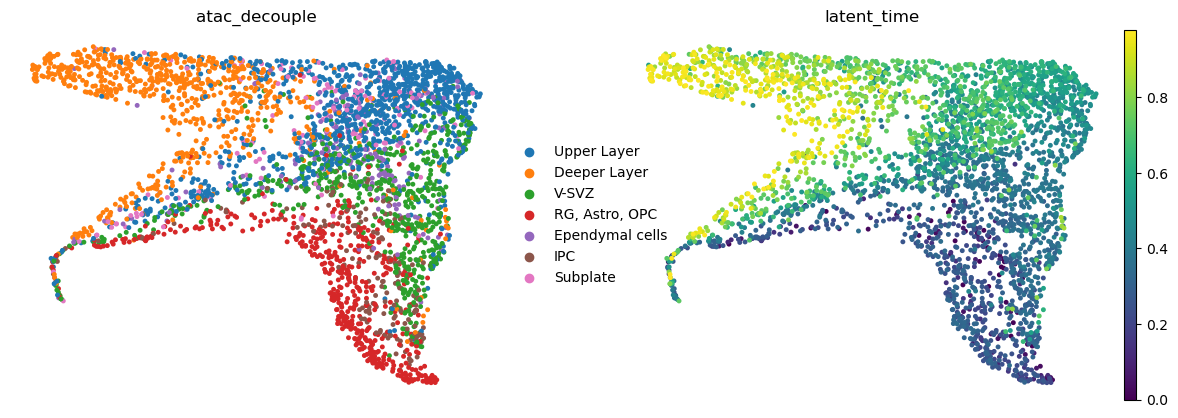

In [17]:
adata_mvi.obsm["latent"] = latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=15, metric="manhattan")

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])

sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="atac_decouple")
plt.show()

In [ ]:
sc.pl.umap(adata_mvi,color=decouple_genes, s=50, frameon=False, ncols=3, vmax='p99',  cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["blood"]], as_cmap=True))


In [ ]:
sc.pl.umap(adata_mvi,color=['celltype', "latent_time", ""], s=50, frameon=False, ncols=2, vmax='p99', title="atac_decouple")


In [1]:
loadmatrix = model.get_atac_loading()
loadmatrix.shape

NameError: name 'model' is not defined

[Text(0.5, 14.722222222222216, 'Peaks')]

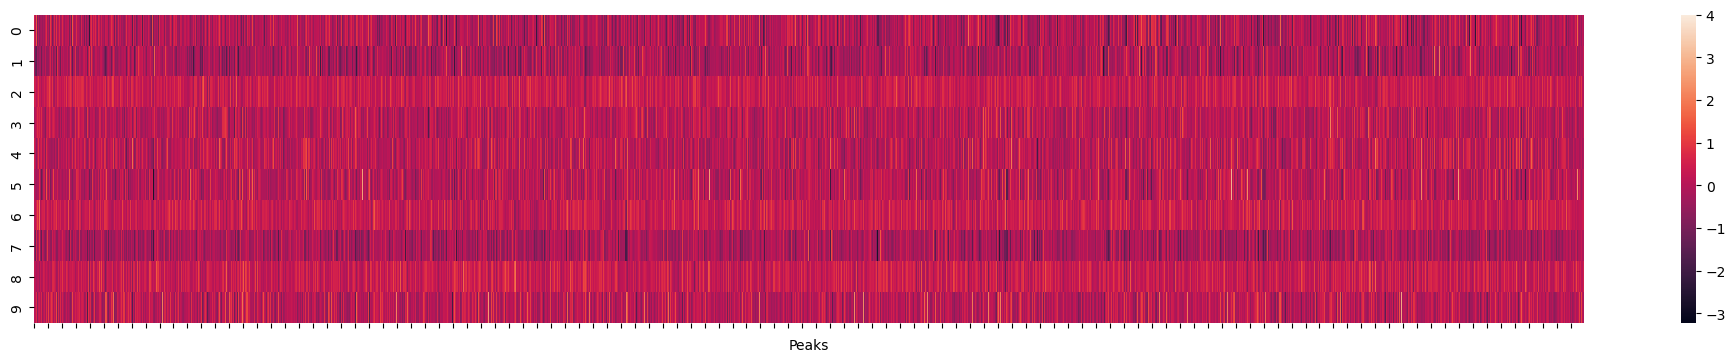

In [33]:
import seaborn as sns
plt.figure(figsize=(25,4))
hm = sns.heatmap(loadmatrix.T)
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks")  # remove the axis label

[Text(0.5, 14.722222222222216, 'genes')]

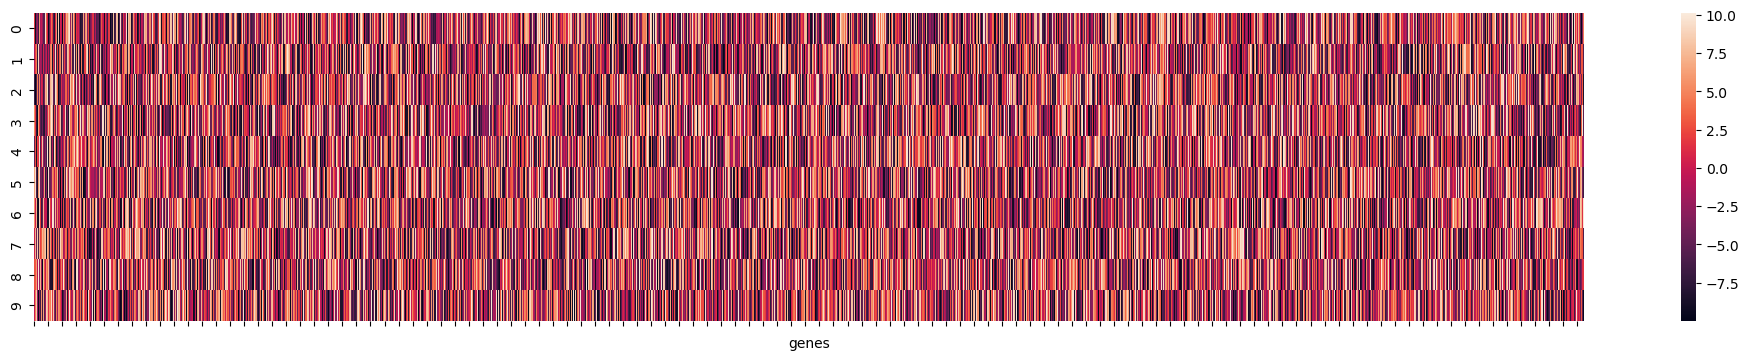

In [35]:
rnaloading = model.module.get_loadings()
plt.figure(figsize=(25,4))
hm = sns.heatmap(rnaloading.T)
hm.set(xticklabels=[]) 
hm.set(xlabel="genes")

In [37]:
## anaylises decouple and couple genes:
rnaloading = rnaloading.T
genes_num = rnaloading.shape[1]
decouple = []
couple = []
for i in range(genes_num):
    couple_latent = rnaloading[:5, i]
    decouple_latent = rnaloading[5:,i]
    if np.all(couple_latent >0) and np.all(decouple_latent <=0):
        couple.append(i)

    elif np.all(decouple_latent > 0) and np.all(couple_latent <=0):
        decouple.append(i)

print("whole genes :{}, coupled genes : {}, decoupled genes: {}".format(genes_num, len(couple), len(decouple)))          




whole genes :14583, coupled genes : 16, decoupled genes: 14


In [1]:
## with soft threshold of decouple and couple genes
genes_num = rnaloading.shape[1]
decouple = []
couple = []
for i in range(genes_num):
    couple_latent = rnaloading[:5, i]
    decouple_latent = rnaloading[5:,i]
    if np.min(couple_latent) >-2 and np.max(decouple_latent) < 2:
        couple.append(i)

    elif np.min(decouple_latent) >-2 and np.max(couple_latent) < 2:
        decouple.append(i)

print("whole genes :{}, coupled peaks : {}, decoupled peaks: {}".format(genes_num, len(couple), len(decouple)))          


NameError: name 'rnaloading' is not defined

In [43]:
## with soft threshold of decouple and couple genes
genes_num = rnaloading.shape[1]
decouple = []
couple = []
for i in range(genes_num):
    couple_latent = rnaloading[:5, i]
    decouple_latent = rnaloading[5:,i]
    if np.all(couple_latent >= decouple_latent):
        couple.append(i)

    elif np.all(decouple_latent > couple_latent):
        decouple.append(i)

print("whole genes :{}, coupled genes : {}, decoupled genes: {}".format(genes_num, len(couple), len(decouple)))          


whole genes :14583, coupled genes : 458, decoupled genes: 480


In [38]:
loadmatrix = loadmatrix.T
peaks_num = loadmatrix.shape[1]
pdecouple = []
pcouple = []
for i in range(genes_num):
    couple_latent = loadmatrix[:5, i]
    decouple_latent = loadmatrix[5:,i]
    if np.all(couple_latent >0) and np.all(decouple_latent <=0):
        pcouple.append(i)

    elif np.all(decouple_latent > 0) and np.all(couple_latent <=0):
        pdecouple.append(i)

print("whole genes :{}, coupled genes : {}, decoupled genes: {}".format(peaks_num, len(pcouple), len(pdecouple)))        

whole genes :123883, coupled genes : 4, decoupled genes: 4


In [47]:
peaks_num = loadmatrix.shape[1]
pdecouple = []
pcouple = []
for i in range(genes_num):
    couple_latent = loadmatrix[:5, i]
    decouple_latent = loadmatrix[5:,i]
    if np.all(couple_latent >= decouple_latent):
        pcouple.append(i)

    elif np.all(decouple_latent > couple_latent):
        pdecouple.append(i)

print("whole genes :{}, coupled peaks : {}, decoupled peaks: {}".format(peaks_num, len(pcouple), len(pdecouple)))        

whole genes :123883, coupled peaks : 180, decoupled peaks: 378


In [55]:
np.savetxt("loading_neural_causal.txt", loadmatrix.T)

In [49]:
def split_loadmatrix(loadmatrix):

    split = np.split(np.abs(loadmatrix), 2, axis=0)
    decouple = np.mean(split[0], axis=0)
    couple = np.mean(split[1], axis=0)
    return decouple, couple

def threshold_matrix(matrix, thresh):
    matrix_new = (matrix > thresh) * matrix
    return matrix_new


decouple, couple = split_loadmatrix(loadmatrix)


<AxesSubplot:ylabel='Count'>

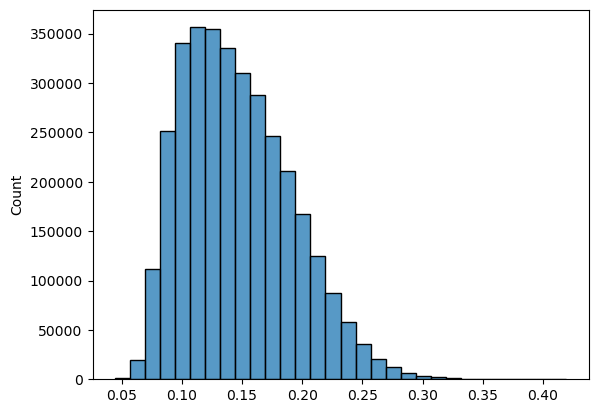

In [34]:
sns.histplot(data=decouple, bins=30)

<AxesSubplot:ylabel='Count'>

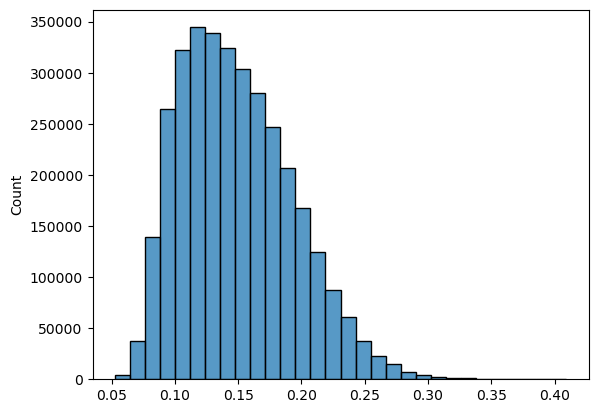

In [35]:
sns.histplot(data=couple, bins=30)

In [53]:
thresh_decouple = threshold_matrix(decouple, 0.2)
thresh_couple = threshold_matrix(couple, 0.2)


[Text(0.5, 23.52222222222222, 'Peaks')]

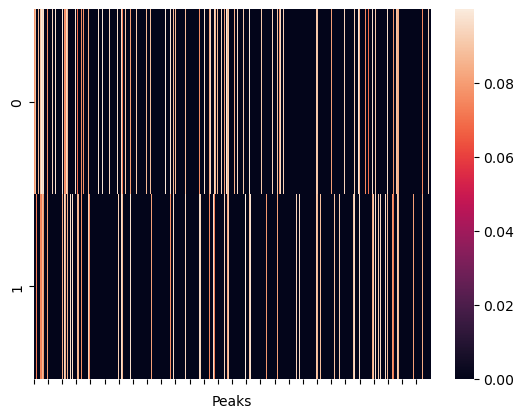

In [38]:
fig, ax = plt.subplots(1)

hm = sns.heatmap(data=[thresh_decouple, thresh_couple])
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks")  # remove the axis label

[Text(0.5, 23.52222222222222, 'Peaks')]

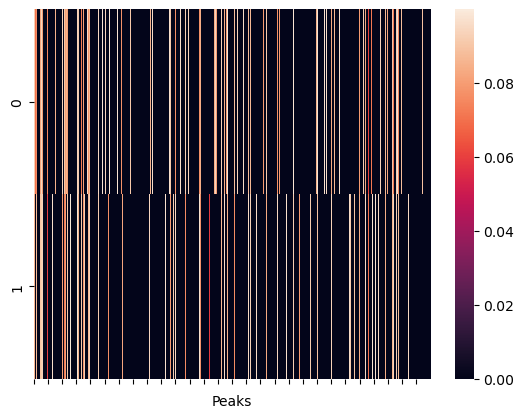

In [40]:
fig, ax = plt.subplots(1)

hm = sns.heatmap(data=[thresh_decouple, thresh_couple])
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks")  # remove the axis label


In [54]:
decouple_index = np.arange(len(decouple))[thresh_decouple > thresh_couple]
print(decouple_index.shape)

couple_index = np.arange(len(couple))[thresh_couple > thresh_decouple]
print(couple_index.shape)

(240113,)
(244785,)


In [50]:
decouple_index

array([     25,      29,      36, ..., 3344810, 3344826, 3344839])

(2, 3344841)


[Text(0.5, -7.277777777777782, 'Peaks')]

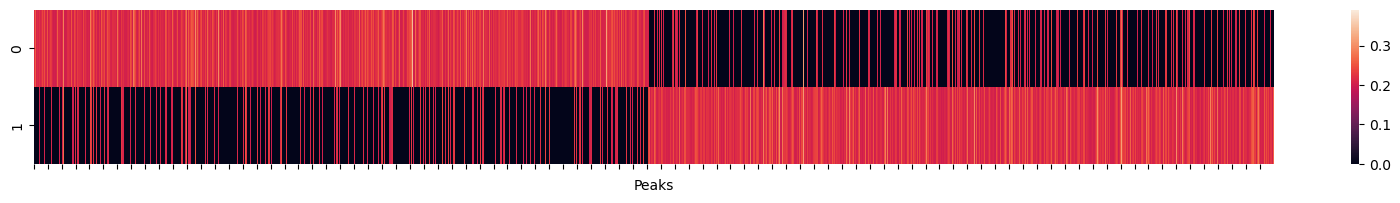

In [55]:
plt.figure(figsize=(20,2))

thresh_index = np.concatenate((decouple_index, couple_index))
# thresh_index = np.sort(thresh_index)
# print(thresh_index.shape)
data = np.array([thresh_decouple, thresh_couple])
print(data.shape)
data = data[:, thresh_index]
hm = sns.heatmap(data=data)
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks")  # remove the axis label

(2, 3344841)


[Text(0.5, 23.52222222222222, 'Peaks')]

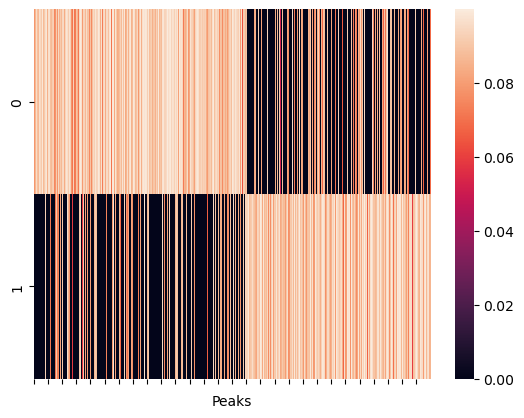

In [41]:
thresh_index = np.concatenate((decouple_index, couple_index))
# thresh_index = np.sort(thresh_index)
# print(thresh_index.shape)
data = np.array([thresh_decouple, thresh_couple])
print(data.shape)
data = data[:, thresh_index]
hm = sns.heatmap(data=data)
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks")  # remove the axis label

In [8]:
model.module.set_train_params(expr_train=True, acc_train=False)
model.train(max_epochs=200, batch_size=32)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=200 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [19:57<00:00,  5.99s/it, loss=9.58e+03, v_num=1]


In [11]:
model.module.set_gates_finetune(True)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=10, batch_size=32)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=10 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [01:47<00:00, 10.74s/it, loss=1.17e+05, v_num=1]


In [14]:
model.module.set_gates_finetune(True)
model.module.set_train_params(expr_train=True, acc_train=True)
model.module.set_finetune_params(1)
model.train(max_epochs=10, batch_size=32)


/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=10 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [01:41<00:00, 10.11s/it, loss=9.4e+04, v_num=1] 


In [15]:
model.module.set_gates_finetune(True)
model.module.set_train_params(expr_train=True, acc_train=True)
model.module.set_finetune_params(2)
model.train(max_epochs=200, batch_size=32)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=200 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [44:26<00:00, 13.33s/it, loss=2.26e+05, v_num=1]


In [24]:
model.save("model_sparse_BM_mouse",overwrite=True)

In [12]:
model = model.load("model_sparse_BM_mouse_nocausal", adata_mvi)

INFO     File model_sparse_BM_mouse_nocausal/model.pt already downloaded                     
n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 8, n_hidden_global 128, n_cat_list [1], *cat_list 1


torch.cat(latent_expr).numpy(), torch.cat(latent_atac).numpy(), \
            torch.cat(latent_expr_dep).numpy(), torch.cat(latent_atac_dep).numpy(), \
                torch.cat(latent_expr_indep).numpy(), torch.cat(latent_atac_indep).numpy(), torch.cat(times).numpy()
    

In [13]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

In [27]:
from complementary_models import torch_infer_nonsta_dir


latent_atac_indep = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')

score3, _, _ = torch_infer_nonsta_dir(latent_atac_indep, latent_expr_indep, times)
score4, _, _ = torch_infer_nonsta_dir(latent_expr_indep, latent_atac_indep, times)
print("score3 {} and score4 {}".format(score3, score4))
score3 - score4

score3 0.06000580433759084 and score4 0.06475627974235859


tensor(-0.0048, device='cuda:0', dtype=torch.float64)

In [23]:
latent_atac_dep = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep = torch.tensor(latent_expr_dep).to('cuda')
times = torch.tensor(times).to('cuda')

score1, _, _ = torch_infer_nonsta_dir(latent_atac_dep, latent_expr_dep, times)
score2, _, _ = torch_infer_nonsta_dir(latent_expr_dep, latent_atac_dep, times)
print("score1 {} and score2 {}".format(score1, score2))
score1 - score2

/tmp/ipykernel_3631/565166213.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times = torch.tensor(times).to('cuda')


score1 0.06456173290428471 and score2 0.06465445089796981


tensor(-9.2718e-05, device='cuda:0', dtype=torch.float64)

In [ ]:

## Test clustering results
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

In [ ]:
# adata_mvi.obsm["X_scVI"] = latent_expr
# latent_expr.shape

latent_rep = np.concatenate((latent_expr, latent_acc), axis=1)
latent_rep.shape

(3365, 20)

In [ ]:
adata_mvi.obsm["latent_rep"] = latent_acc

In [ ]:
sc.pp.neighbors(adata_mvi, use_rep="latent_rep")
sc.tl.umap(adata_mvi, min_dist=0.3)


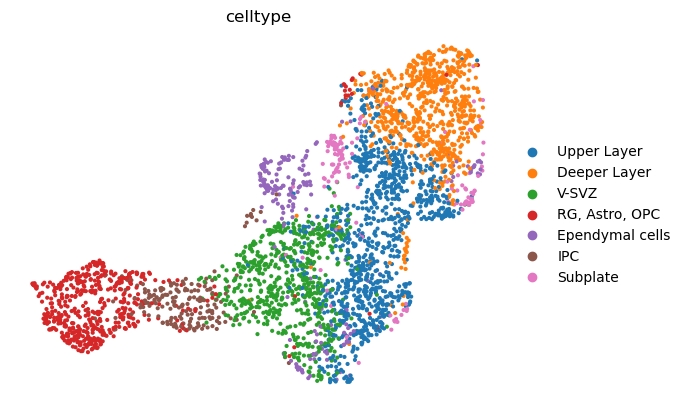

In [ ]:
sc.pl.umap(
    adata_mvi,
    color=["celltype"],
    frameon=False,
)

In [ ]:
sc.tl.leiden(adata_mvi, key_added="leiden_latent", resolution=0.4)


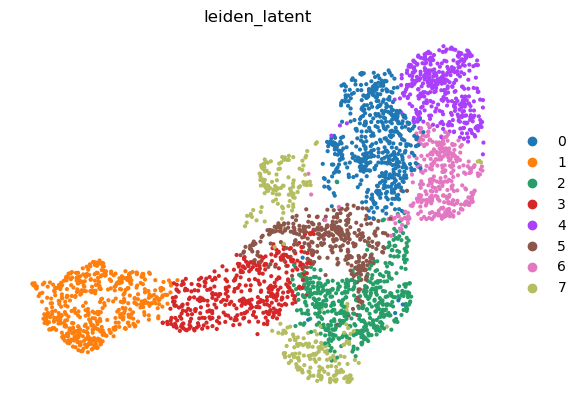

In [ ]:
sc.pl.umap(
    adata_mvi,
    color=["leiden_latent"],
    frameon=False,
)